In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
from ta.momentum import rsi
import pyodbc
import quantstats as qs
from Rolling_Functions_Final import * 

## Basic Set Up

In [2]:
list_of_codes = ['512890', '159967']
data = Rolling.get_data(list_of_codes)

Here at starting from the longest period


In [3]:
window_list = [3,6,9,12,15,18,21,24,27]
optimized_table = Rolling.rolling_optimization_table(data, window_list, len(list_of_codes))

In [4]:
## Provide Signal ONLY 
## Make sure to shift(1) afterwards


def signal_only(data, window_list, target_num):
        """

        :param data: DataFrame from get_data
        :param window_list: [3,6,9,12,15,18,21,24,27]
        :param target_num: len(list_of_codes)

        :return: data_list
        """
        # parameter type: list, DataFrame, int
        
        data_list = []
        A = target_num
        for i in window_list:
            data_x = data.copy()
            signal_name = []
            
            for num, name in enumerate(data_x.columns[A:]):
                data_x[f'{name}_{str(i)}'] = data_x[data_x.columns[num]].rolling(window=i).apply(lambda x: x[-1]/x[0])
                signal_name.append(f'signal_{data_x.columns[num][4:]}')
            
            # data_x = data_x.iloc[i:,:]
            for name in signal_name:
                data_x[name] = [0] * len(data_x)
            
            for row in range(len(data_x)):
                value = data_x.iloc[row][2*A:3*A].max()
                series = data_x.iloc[row]
                try:
                    position = series[2*A:3*A][series == value].idxmax()
                except:
                    continue
                old_position = series.index.get_loc(position)
                new_position = old_position + A
                data_x.loc[data_x.index[row],series.index[new_position]] = 1
            
        return data_x

In [5]:
# def func():
#     import pdb; pdb.set_trace()
#     Rolling.rolling_optimization_table(data, window_list, len(list_of_codes))
# func()

In [6]:
def dynamic_window_table(data, window_list, target_num, days):
        """

        :param data: DataFrame from get_data
        :param window_list: [3,6,9,12,15,18,21,24,27]
        :param target_num: len(list_of_codes)

        :return: data_list
        """
        # parameter type: list, DataFrame, int
        
        # Make all the tables ready with different windows from the window list
        # print(f'The input data index starts from {data.index[0]} till {data.index[-1]}')
        data_copy = data.copy()
        window_dict = {}
        last_window = 0
        for window in window_list:
             window_signal = signal_only(data_copy, [window], target_num)
             window_dict[window] = window_signal.iloc[:,-target_num:]
        print('Below is the window_dict, shows each window_size and its corresponding signal distribution')
        print(window_dict)
        print('___________________________________________________________________\n')
        # Set up 
        A = target_num
        signal_collecter = pd.DataFrame()

        optimized_table = Rolling.rolling_optimization_table(data, window_list, A)
        print('Below is the opyimized_table, gathering all the windows in the window_list and show each of their final return')
        print(optimized_table)
        print('_______________________________________________________________________\n')


        print(f'Optimized_table has length {len(optimized_table)}')
        print(f'Data has length {len(data)}')
        print(f'The above length difference should follow that length of data - length of optimized_table = min(window_list) + 1 days')
        print(f'The min(window)list here is {min(window_list)} and length of data - length of optimized_table is {len(data) - len(optimized_table)}')
        print('_______________________________________________________________________\n')
        # Each Specific days the new window will be decided based on the past Specific days performance 
        for i in range(0,len(optimized_table)+days,days):
            print(f'Here we are at {i} and signal_collecter has length of {len(signal_collecter)} with the length of data at {len(data)}\n')
            reference_dict = {}
            if i + 2* days >= len(optimized_table):
                print("*******************************************Here is reached!!!!!!!!!!!!!!!!!!!!!!!!!!")
                reference_table = optimized_table.iloc[len(signal_collecter):,:]
                print(f'The look back period here from {optimized_table.index[i]} to {optimized_table.index[-1]}')
                 
            else:
                print(f'The look back period here from {optimized_table.index[i]} to {optimized_table.index[i+days-1]}')
                reference_table = optimized_table.iloc[i:i+days,:]
            ################# print(reference_table)
            
            for column in reference_table.columns:
                first_value = reference_table.iloc[0][column]
                last_value = reference_table.iloc[-1][column]
                result = last_value / first_value
                reference_dict[column] = result
            print(reference_dict)

            rounded_result = []
            key_result = []
            for key, value in reference_dict.items():
                 rounded_values = round(value, 3)
                 rounded_result.append(rounded_values)
                 key_result.append(key)
            # print(f'Here is our rounded results {rounded_result}')
            # print(f'Here is our key results {key_result}')
            ## Decide the window to use for the next Specific days
            max_key = int(max(reference_dict, key=lambda k: reference_dict[k])[14:])
            ################# print(reference_dict.index)

            # Here means the Max Key needs to be revised as there are multiple largest return 
            if rounded_result.count(max(rounded_result)) > 1:
                print(f'There are Repeating Max Return! Now we will select the one based on the last window {last_window}\n')
                print(f'The repeating max return here is {max(rounded_result)}')
                max_indices = [index for index, value in enumerate(rounded_result) if value == max(rounded_result)]  # Get indices of all occurrences of the maximum value
                # print(f'The repeating max return here is {max_indices}')
                values = [key_result[index] for index in max_indices]
                # print(f'Consequently, the corresponding keys are {values}')
                values = [int(value[14:]) for value in values]
                print(f'Here are the repeating windows: {values} given the last window was {last_window}')
                # print(f'The last window is {last_window}')

                closest_key = None

                for key in values:
                    # print(f'We have reached this rotation of key when key is {key}')
                    ## Change Close_Key when the next key has a smaller gap than the former
                    if closest_key is None or (abs(key - last_window) < abs(closest_key - last_window)):
                        closest_key = key
                        # print(f'We are at Step 1 and the cloest_key here was {closest_key} ')
                    if (abs(key - last_window) == abs(closest_key - last_window)) and key > closest_key:
                        closest_key = key
                            # print(f'We have reached Step 2 and the cloest_key now is {closest_key}')
                            
                # print('\n')
                # print(f'HENCE, our supposed choice of Max_Key should be {closest_key}')
                max_key = closest_key
            
            print(f'For the {int((i+days)/days)}th rotation, the window of choice is {max_key}\n')
           
            
            ################ print("_________________________________________________________________\n")
            # print(reference_table.index)

            selected_window_signal = window_dict[max_key].loc[optimized_table.iloc[i+days:i+2*days,:].index]
            print(selected_window_signal)
            print('\n')
            print('\n')
            signal_collecter = pd.concat([signal_collecter, selected_window_signal], axis=0, ignore_index=False)
            last_window = max_key
            if len(signal_collecter) >= len(data) - 4:
                 break
            if i + 2* days >= len(optimized_table):
                 break
            ################# print(f'The signal_collecter length now is {len(signal_collecter)}\n')
        
        ## Combine the data with the signal 
        data_x = data.loc[signal_collecter.index]
        data_x = pd.concat([data_x, signal_collecter], axis=1, ignore_index=False)
        ############## print(data_x)

        ## Now we calculate the return based on signals
        for name in data_x.columns[-A:]:
                data_x[name] = data_x[name].shift(1)
            
        data_x = data_x[1:]
        
        data_x['Dynamic_signal_return'] = [0] * len(data_x)
        arr = []
            
        for row in range(len(data_x)):
            value = data_x.iloc[row][2*A:3*A].max()
            series = data_x.iloc[row]
            ## find the position of signal with 1 
            position = series[2*A:3*A][series == value].idxmax()
            old_position = series.index.get_loc(position)
            new_position = old_position - A
            arr.append(series[new_position] + 1)
            
        data_x['arr'] = arr
        data_x['Dynamic_signal_return'] = np.cumprod(arr, axis=0)*100
        


        data_x['Dynamic_signal_return'] = (100/data_x['Dynamic_signal_return'].values[0]) * data_x['Dynamic_signal_return'] 
        ##################### print(f'This is {days} period rolling, we have the length of {len(signal_collecter)}\n')
        return data_x,signal_collecter
        
             

In [7]:
dynamic_table_21, signal_21 = dynamic_window_table(data,window_list,len(list_of_codes),21)
dynamic_table_63, signal_63 = dynamic_window_table(data,window_list,len(list_of_codes),63)
dynamic_table_42, signal_42 = dynamic_window_table(data,window_list,len(list_of_codes),42)
dynamic_table_84, signal_84 = dynamic_window_table(data,window_list,len(list_of_codes),84)
dynamic_table_15, signal_15 = dynamic_window_table(data,window_list,len(list_of_codes),15)
dynamic_table_126, signal_126 = dynamic_window_table(data,window_list,len(list_of_codes),126)
dynamic_table_5, signal_5 = dynamic_window_table(data,window_list,len(list_of_codes),5)
dynamic_table_10, signal_10 = dynamic_window_table(data,window_list,len(list_of_codes),10)

Below is the window_dict, shows each window_size and its corresponding signal distribution
{3:             signal_512890  signal_159967
EndDate                                 
2018-12-21              0              0
2018-12-28              0              0
2018-12-31              1              0
2019-01-04              1              0
2019-01-10              1              0
...                   ...            ...
2023-07-06              1              0
2023-07-07              1              0
2023-07-10              1              0
2023-07-11              0              1
2023-07-12              1              0

[1096 rows x 2 columns], 6:             signal_512890  signal_159967
EndDate                                 
2018-12-21              0              0
2018-12-28              0              0
2018-12-31              0              0
2019-01-04              0              0
2019-01-10              0              0
...                   ...            ...
2023-07-06     

In [8]:
dynamic_table_63 = dynamic_table_63.iloc[-965:,:]
dynamic_table_63['Dynamic_signal_return'] = (dynamic_table_63['Dynamic_signal_return']*100)/dynamic_table_63['Dynamic_signal_return'][0]

## - 

## - 

## - 

## 端木的测试

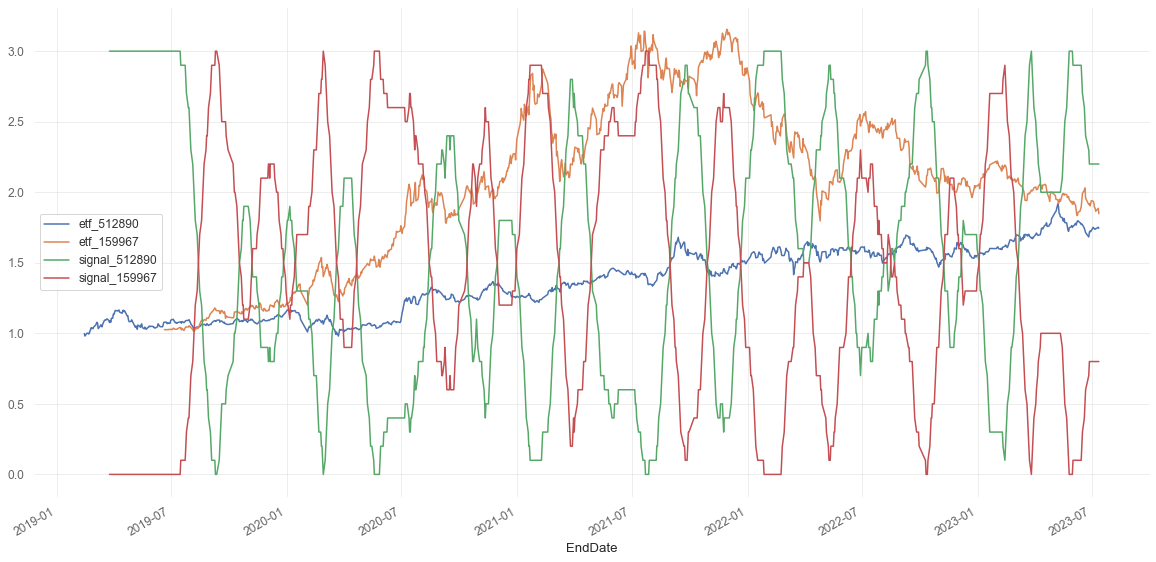

In [9]:
ax=(dynamic_table_15[['etf_512890','etf_159967']].pct_change() + 1).cumprod().plot()
# plt.show()
((dynamic_table_15[['signal_512890','signal_159967']]).rolling(30).sum()/10).plot(figsize=(20,10),ax=ax)
plt.legend()

<AxesSubplot:xlabel='EndDate'>

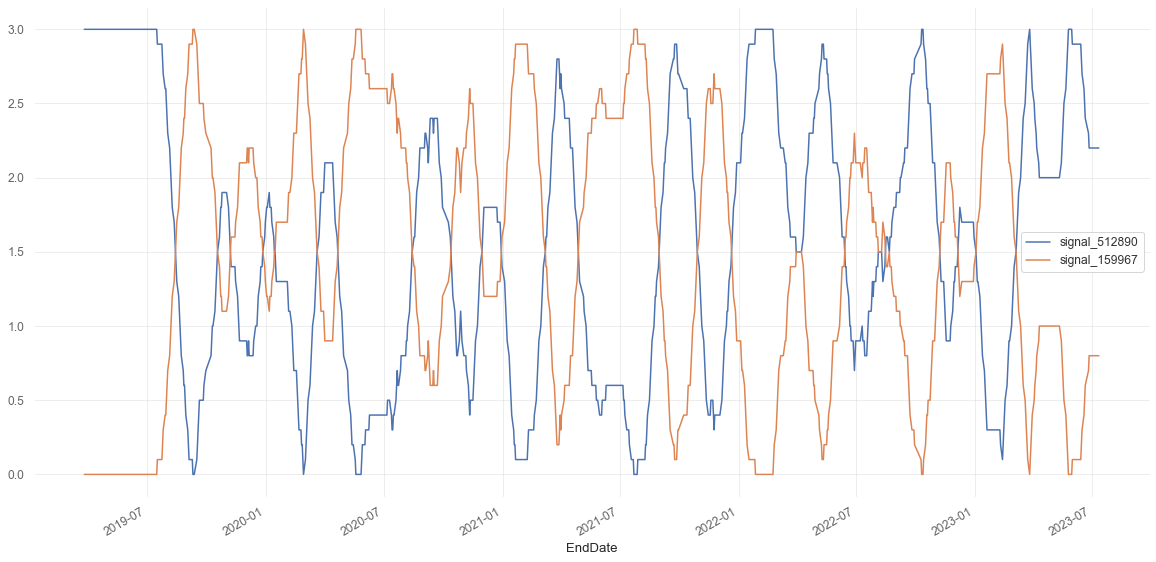

In [10]:
((dynamic_table_15[['signal_512890','signal_159967']]).rolling(30).sum()/10).plot(figsize=(20,10))

In [11]:
(dynamic_table_15.arr-1).mean()*250*.2

0.05907202522781312

In [12]:
.16*.2

0.032

In [13]:
(dynamic_table_15[['signal_512890','signal_159967']].iloc[1:].stack() - dynamic_table_15[['signal_512890','signal_159967']].shift().stack()).abs().groupby(level=0).sum().sum() / dynamic_table_15[['signal_512890','signal_159967']].iloc[1:].shape[0]*250

72.55813953488371

<AxesSubplot:xlabel='EndDate'>

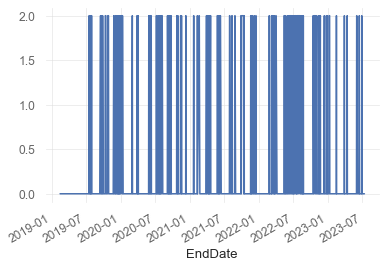

In [14]:
(dynamic_table_15[['signal_512890','signal_159967']].iloc[1:].stack() - dynamic_table_15[['signal_512890','signal_159967']].shift().stack()).abs().groupby(level=0).sum().plot()

In [15]:
(dynamic_table_15.arr - 1).rolling(250).sum().iloc[::250]

EndDate
2019-02-13         NaN
2020-02-20    0.388132
2021-03-02    0.518341
2022-03-11    0.287611
2023-03-21   -0.002343
Name: arr, dtype: float64

In [16]:
dynamic_table_15[['etf_512890_day_return','etf_159967_day_return']].rolling(250).sum().iloc[::250]

,etf_512890_day_return,etf_159967_day_return
EndDate,,
2019-02-13,NaN,NaN
2020-02-20,0.110991,NaN
2021-03-02,0.190486,0.542852
2022-03-11,0.174347,0.042309
2023-03-21,0.114548,-0.133822


<AxesSubplot:xlabel='EndDate'>

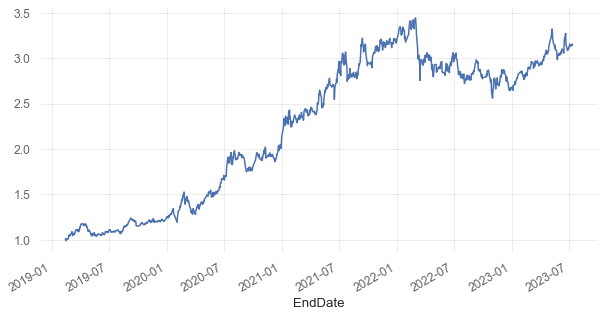

In [17]:
# ax=(dynamic_table_15[['etf_512890']].pct_change() + 1).cumprod().plot(figsize=(10,5))
dynamic_table_15.arr.cumprod().plot(figsize=(10,5))

In [18]:
15*0.84

12.6

In [19]:
(dynamic_table_15.arr-1).mean()*250

0.2953601261390656

In [20]:
(dynamic_table_15.arr > 1).sum() / dynamic_table_15.shape[0]

0.5260223048327137

In [21]:
(dynamic_table_15.arr-1).std()*250**(0.5)

0.24095945717161218

In [22]:
(dynamic_table_15.arr.cumprod() / dynamic_table_15.arr.cumprod().cummax()).min() - 1

-0.25636366782133335

<AxesSubplot:xlabel='EndDate'>

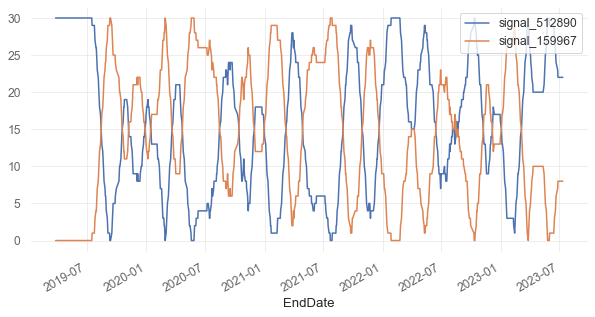

In [23]:
(dynamic_table_15[['signal_512890','signal_159967']]).rolling(30).sum().plot(figsize=(10,5))

In [24]:
dynamic_table_15['etf_512890'].pct_change().mean()*250/dynamic_table_15['etf_512890'].pct_change().std()/250**(0.5)

0.8128562403244682

In [25]:
dynamic_table_15['etf_159967'].pct_change().mean()*250/dynamic_table_15['etf_159967'].pct_change().std()/250**(0.5)

0.6777277947637211

In [26]:
dynamic_table_15[['etf_512890','etf_159967']].mean(axis=1).pct_change().mean()*250/dynamic_table_15[['etf_512890','etf_159967']].mean(axis=1).pct_change().std()/250**(0.5)

0.7081483298454087

In [27]:
(dynamic_table_15['arr']-1).mean()*250/(dynamic_table_15['arr']-1).std()/250**(0.5)

1.2257668970789102

In [28]:
((dynamic_table_15['arr']-1) == dynamic_table_15.etf_512890.pct_change()).sum()

569

In [29]:
((dynamic_table_15['arr']-1) == dynamic_table_15.etf_159967.pct_change()).sum()

504

## -

## -

## -

## Result Testing

In [30]:
dynamic_table_21, signal_21 = dynamic_window_table(data,window_list,len(list_of_codes),21)
dynamic_table_63, signal_63 = dynamic_window_table(data,window_list,len(list_of_codes),63)
dynamic_table_42, signal_42 = dynamic_window_table(data,window_list,len(list_of_codes),42)
dynamic_table_84, signal_84 = dynamic_window_table(data,window_list,len(list_of_codes),84)
dynamic_table_15, signal_15 = dynamic_window_table(data,window_list,len(list_of_codes),15)
dynamic_table_126, signal_126 = dynamic_window_table(data,window_list,len(list_of_codes),126)
dynamic_table_5, signal_5 = dynamic_window_table(data,window_list,len(list_of_codes),5)
dynamic_table_10, signal_10 = dynamic_window_table(data,window_list,len(list_of_codes),10)

Below is the window_dict, shows each window_size and its corresponding signal distribution
{3:             signal_512890  signal_159967
EndDate                                 
2018-12-21              0              0
2018-12-28              0              0
2018-12-31              1              0
2019-01-04              1              0
2019-01-10              1              0
...                   ...            ...
2023-07-06              1              0
2023-07-07              1              0
2023-07-10              1              0
2023-07-11              0              1
2023-07-12              1              0

[1096 rows x 2 columns], 6:             signal_512890  signal_159967
EndDate                                 
2018-12-21              0              0
2018-12-28              0              0
2018-12-31              0              0
2019-01-04              0              0
2019-01-10              0              0
...                   ...            ...
2023-07-06     

In [31]:
optimized_table = Rolling.rolling_optimization_table(data, window_list, len(list_of_codes))

#### Evaluation under unequal length

In [32]:
print(len(dynamic_table_15))
print(len(dynamic_table_21))
print(len(dynamic_table_42))
print(len(dynamic_table_63))
print(len(dynamic_table_84))
print(len(dynamic_table_126))

print("\n")
print(len(optimized_table))

1076
1070
1049
1028
1007
965


1092


In [33]:
print(dynamic_table_15.loc[:,'Dynamic_signal_return'][-1])
print(dynamic_table_21.loc[:,'Dynamic_signal_return'][-1])
print(dynamic_table_42.loc[:,'Dynamic_signal_return'][-1])
print(dynamic_table_63.loc[:,'Dynamic_signal_return'][-1])
print(dynamic_table_84.loc[:,'Dynamic_signal_return'][-1])
print(dynamic_table_126.loc[:,'Dynamic_signal_return'][-1])
print("\n")
print(optimized_table.loc[:,'signal_return_3'][-1])
print(optimized_table.loc[:,'signal_return_6'][-1])
print(optimized_table.loc[:,'signal_return_9'][-1])
print(optimized_table.loc[:,'signal_return_12'][-1])
print(optimized_table.loc[:,'signal_return_15'][-1])
print(optimized_table.loc[:,'signal_return_18'][-1])
print(optimized_table.loc[:,'signal_return_21'][-1])
print(optimized_table.loc[:,'signal_return_24'][-1])
print(optimized_table.loc[:,'signal_return_27'][-1])

311.1310901290398
265.59786793619287
326.0024584848557
212.6113325128668
256.6681606710004
388.627038870085


272.4767608314067
301.29540378137847
415.85954702612355
338.53351725064647
271.6180191652014
308.3108314281719
387.31733778331306
370.52636838276175
345.6885657390562


In [34]:
data_plot = data.copy()
data_plot['etf_512890_return'] = data_plot['etf_512890']*(100/data_plot.loc[:,"etf_512890"][0])
data_plot['etf_159967_return'] = data_plot['etf_159967']*(100/data_plot.loc[:,"etf_159967"][124])

In [35]:
Sharpe_512890 = Test.get_Sharpe(data_plot, 'etf_512890_return')
Sharpe_159967 = Test.get_Sharpe(data_plot, 'etf_159967_return')
Sharpe_3 = Test.get_Sharpe(optimized_table, 'signal_return_3')
Sharpe_6 = Test.get_Sharpe(optimized_table, 'signal_return_6')
Sharpe_9 = Test.get_Sharpe(optimized_table, 'signal_return_9')
Sharpe_12 = Test.get_Sharpe(optimized_table, 'signal_return_12')
Sharpe_15 = Test.get_Sharpe(optimized_table, 'signal_return_15')
Sharpe_18 = Test.get_Sharpe(optimized_table, 'signal_return_18')
Sharpe_21 = Test.get_Sharpe(optimized_table, 'signal_return_21')
Sharpe_24 = Test.get_Sharpe(optimized_table, 'signal_return_24')
Sharpe_27 = Test.get_Sharpe(optimized_table, 'signal_return_27')
Sharpe_Dynamic_63 = Test.get_Sharpe(dynamic_table_63, 'Dynamic_signal_return')
Sharpe_Dynamic_42 = Test.get_Sharpe(dynamic_table_42, 'Dynamic_signal_return')
Sharpe_Dynamic_84 = Test.get_Sharpe(dynamic_table_84, 'Dynamic_signal_return')
Sharpe_Dynamic_15 = Test.get_Sharpe(dynamic_table_15, 'Dynamic_signal_return')
Sharpe_Dynamic_5 = Test.get_Sharpe(dynamic_table_5, 'Dynamic_signal_return')
Sharpe_Dynamic_10 = Test.get_Sharpe(dynamic_table_10, 'Dynamic_signal_return')
Sharpe_Dynamic_126 = Test.get_Sharpe(dynamic_table_126, 'Dynamic_signal_return')
Sharpe_Dynamic_21 = Test.get_Sharpe(dynamic_table_21, 'Dynamic_signal_return')

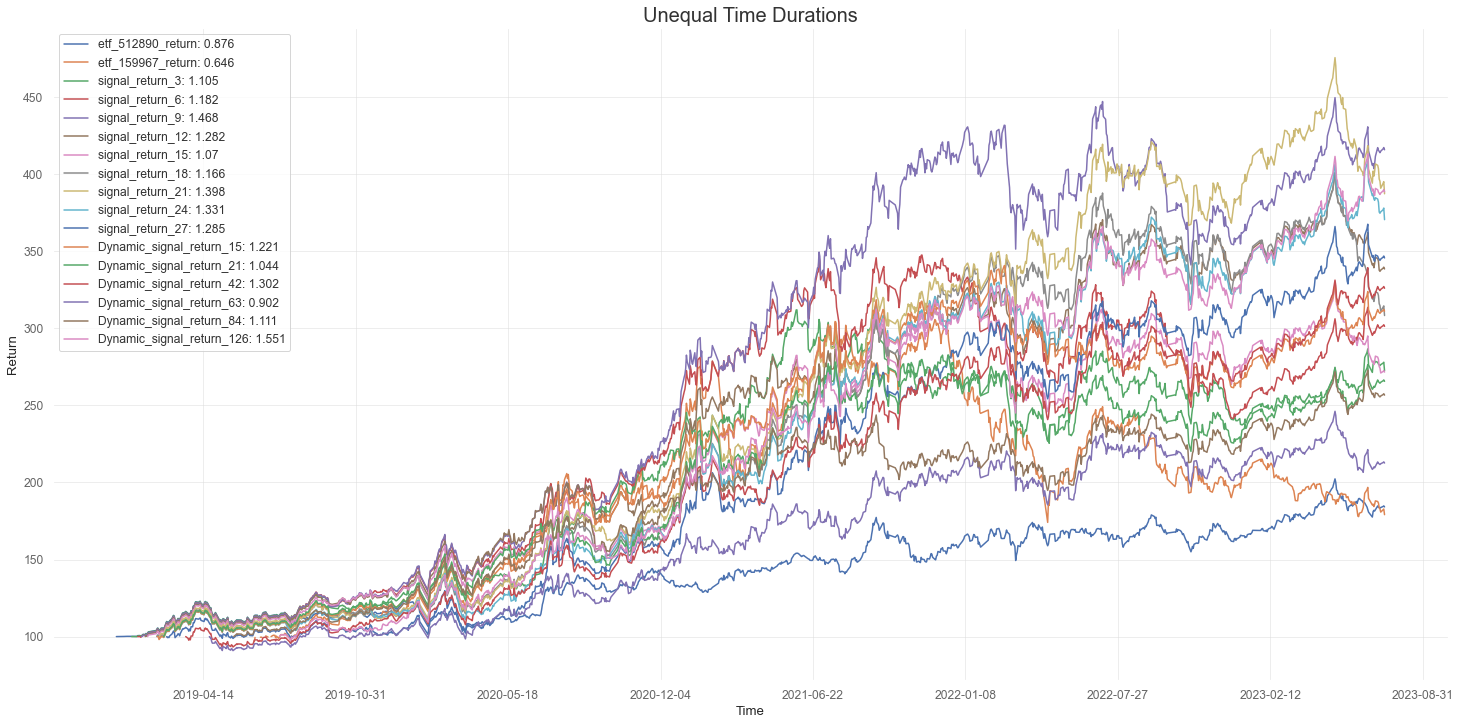

In [36]:
_ = plt.figure(figsize=(25, 12))
plt.xlabel('Time') 
plt.ylabel('Return')

_ = plt.plot(np.array(data_plot['etf_512890_return'].index),data_plot['etf_512890_return'].values)
_ = plt.plot(np.array(data_plot['etf_159967_return'] .index),data_plot['etf_159967_return'].values)


_ = plt.plot(np.array(optimized_table["signal_return_3"].index),optimized_table["signal_return_3"].values)
_ = plt.plot(np.array(optimized_table["signal_return_6"].index),optimized_table["signal_return_6"].values)
_ = plt.plot(np.array(optimized_table["signal_return_9"].index),optimized_table["signal_return_9"].values)
_ = plt.plot(np.array(optimized_table["signal_return_12"].index),optimized_table["signal_return_12"].values)
_ = plt.plot(np.array(optimized_table["signal_return_15"].index),optimized_table["signal_return_15"].values)
_ = plt.plot(np.array(optimized_table["signal_return_18"].index),optimized_table["signal_return_18"].values)
_ = plt.plot(np.array(optimized_table["signal_return_21"].index),optimized_table["signal_return_21"].values)
_ = plt.plot(np.array(optimized_table["signal_return_24"].index),optimized_table["signal_return_24"].values)
_ = plt.plot(np.array(optimized_table["signal_return_27"].index),optimized_table["signal_return_27"].values)


_ = plt.plot(np.array(dynamic_table_15["Dynamic_signal_return"].index),dynamic_table_15["Dynamic_signal_return"].values)
_ = plt.plot(np.array(dynamic_table_21["Dynamic_signal_return"].index),dynamic_table_21["Dynamic_signal_return"].values)
_ = plt.plot(np.array(dynamic_table_42["Dynamic_signal_return"].index),dynamic_table_42["Dynamic_signal_return"].values)
_ = plt.plot(np.array(dynamic_table_63["Dynamic_signal_return"].index),dynamic_table_63["Dynamic_signal_return"].values)
_ = plt.plot(np.array(dynamic_table_84["Dynamic_signal_return"].index),dynamic_table_84["Dynamic_signal_return"].values)
_ = plt.plot(np.array(dynamic_table_126["Dynamic_signal_return"].index),dynamic_table_126["Dynamic_signal_return"].values)



_ = plt.legend([f'etf_512890_return: {round(Sharpe_512890, 3)}', f'etf_159967_return: {round(Sharpe_159967, 3)}', 
                f'signal_return_3: {round(Sharpe_3, 3)}', f'signal_return_6: {round(Sharpe_6, 3)}',
                f'signal_return_9: {round(Sharpe_9, 3)}', f'signal_return_12: {round(Sharpe_12, 3)}',
                f"signal_return_15: {round(Sharpe_15, 3)}", f"signal_return_18: {round(Sharpe_18, 3)}", 
                f"signal_return_21: {round(Sharpe_21, 3)}", f"signal_return_24: {round(Sharpe_24, 3)}", 
                f"signal_return_27: {round(Sharpe_27, 3)}",  
                f"Dynamic_signal_return_15: {round(Sharpe_Dynamic_15, 3)}",f"Dynamic_signal_return_21: {round(Sharpe_Dynamic_21, 3)}", 
                f"Dynamic_signal_return_42: {round(Sharpe_Dynamic_42, 3)}",f"Dynamic_signal_return_63: {round(Sharpe_Dynamic_63, 3)}",
                f"Dynamic_signal_return_84: {round(Sharpe_Dynamic_84, 3)}",f"Dynamic_signal_return_126: {round(Sharpe_Dynamic_126, 3)}"]) 

plt.title("Unequal Time Durations", fontsize=20)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(200))

#### -

#### -

#### Evaluation under the same length

In [37]:
ideal_length = min([len(dynamic_table_15), len(dynamic_table_21), len(dynamic_table_42), len(dynamic_table_63), len(dynamic_table_84), len(dynamic_table_126)])

dynamic_table_15 = dynamic_table_15.iloc[-ideal_length:,:]
dynamic_table_15['Dynamic_signal_return'] = (dynamic_table_15['Dynamic_signal_return']*100)/dynamic_table_15['Dynamic_signal_return'][0]

dynamic_table_21 = dynamic_table_21.iloc[-ideal_length:,:]
dynamic_table_21['Dynamic_signal_return'] = (dynamic_table_21['Dynamic_signal_return']*100)/dynamic_table_21['Dynamic_signal_return'][0]

dynamic_table_42 = dynamic_table_42.iloc[-ideal_length:,:]
dynamic_table_42['Dynamic_signal_return'] = (dynamic_table_42['Dynamic_signal_return']*100)/dynamic_table_42['Dynamic_signal_return'][0]

dynamic_table_63 = dynamic_table_63.iloc[-ideal_length:,:]
dynamic_table_63['Dynamic_signal_return'] = (dynamic_table_63['Dynamic_signal_return']*100)/dynamic_table_63['Dynamic_signal_return'][0]

dynamic_table_84 = dynamic_table_84.iloc[-ideal_length:,:]
dynamic_table_84['Dynamic_signal_return'] = (dynamic_table_84['Dynamic_signal_return']*100)/dynamic_table_84['Dynamic_signal_return'][0]

optimized_table = optimized_table.iloc[-ideal_length:,:]
optimized_table['signal_return_3'] = (optimized_table['signal_return_3']*100)/optimized_table['signal_return_3'][0]
optimized_table['signal_return_6'] = (optimized_table['signal_return_6']*100)/optimized_table['signal_return_6'][0]
optimized_table['signal_return_9'] = (optimized_table['signal_return_9']*100)/optimized_table['signal_return_9'][0]
optimized_table['signal_return_12'] = (optimized_table['signal_return_12']*100)/optimized_table['signal_return_12'][0]
optimized_table['signal_return_15'] = (optimized_table['signal_return_15']*100)/optimized_table['signal_return_15'][0]
optimized_table['signal_return_18'] = (optimized_table['signal_return_18']*100)/optimized_table['signal_return_18'][0]
optimized_table['signal_return_21'] = (optimized_table['signal_return_21']*100)/optimized_table['signal_return_21'][0]
optimized_table['signal_return_24'] = (optimized_table['signal_return_24']*100)/optimized_table['signal_return_24'][0]
optimized_table['signal_return_27'] = (optimized_table['signal_return_27']*100)/optimized_table['signal_return_27'][0]

In [38]:
print(len(dynamic_table_15))
print(len(dynamic_table_21))
print(len(dynamic_table_42))
print(len(dynamic_table_63))
print(len(dynamic_table_84))
print(len(dynamic_table_126))
print(len(optimized_table))

965
965
965
965
965
965
965


In [39]:
print(dynamic_table_15.loc[:,'Dynamic_signal_return'][-1])
print(dynamic_table_21.loc[:,'Dynamic_signal_return'][-1])
print(dynamic_table_42.loc[:,'Dynamic_signal_return'][-1])
print(dynamic_table_63.loc[:,'Dynamic_signal_return'][-1])
print(dynamic_table_84.loc[:,'Dynamic_signal_return'][-1])
print(dynamic_table_126.loc[:,'Dynamic_signal_return'][-1])
print("\n")
print(optimized_table.loc[:,'signal_return_3'][-1])
print(optimized_table.loc[:,'signal_return_6'][-1])
print(optimized_table.loc[:,'signal_return_9'][-1])
print(optimized_table.loc[:,'signal_return_12'][-1])
print(optimized_table.loc[:,'signal_return_15'][-1])
print(optimized_table.loc[:,'signal_return_18'][-1])
print(optimized_table.loc[:,'signal_return_21'][-1])
print(optimized_table.loc[:,'signal_return_24'][-1])
print(optimized_table.loc[:,'signal_return_27'][-1])


288.17439990231946
244.71702200300962
332.97707089702124
222.80296141638684
245.44454874182154
388.627038870085


239.63262761168428
266.2727603452594
367.59307361765747
301.35525618970763
243.4125429817752
282.692811934668
352.0695188608007
343.6808810401611
333.34797331049197


In [40]:
data_plot = data.copy()
data_plot = data_plot.iloc[-ideal_length:,:]
data_plot['etf_512890_return'] = data_plot['etf_512890']*(100/data_plot.loc[:,"etf_512890"][0])
data_plot['etf_159967_return'] = data_plot['etf_159967']*(100/data_plot.loc[:,"etf_159967"][0])
print(len(data_plot))

965


In [41]:
Sharpe_512890 = Test.get_Sharpe(data_plot, 'etf_512890_return')
Sharpe_159967 = Test.get_Sharpe(data_plot, 'etf_159967_return')
Sharpe_3 = Test.get_Sharpe(optimized_table, 'signal_return_3')
Sharpe_6 = Test.get_Sharpe(optimized_table, 'signal_return_6')
Sharpe_9 = Test.get_Sharpe(optimized_table, 'signal_return_9')
Sharpe_12 = Test.get_Sharpe(optimized_table, 'signal_return_12')
Sharpe_15 = Test.get_Sharpe(optimized_table, 'signal_return_15')
Sharpe_18 = Test.get_Sharpe(optimized_table, 'signal_return_18')
Sharpe_21 = Test.get_Sharpe(optimized_table, 'signal_return_21')
Sharpe_24 = Test.get_Sharpe(optimized_table, 'signal_return_24')
Sharpe_27 = Test.get_Sharpe(optimized_table, 'signal_return_27')
Sharpe_Dynamic_63 = Test.get_Sharpe(dynamic_table_63, 'Dynamic_signal_return')
Sharpe_Dynamic_42 = Test.get_Sharpe(dynamic_table_42, 'Dynamic_signal_return')
Sharpe_Dynamic_84 = Test.get_Sharpe(dynamic_table_84, 'Dynamic_signal_return')
Sharpe_Dynamic_15 = Test.get_Sharpe(dynamic_table_15, 'Dynamic_signal_return')
Sharpe_Dynamic_5 = Test.get_Sharpe(dynamic_table_5, 'Dynamic_signal_return')
Sharpe_Dynamic_10 = Test.get_Sharpe(dynamic_table_10, 'Dynamic_signal_return')
Sharpe_Dynamic_126 = Test.get_Sharpe(dynamic_table_126, 'Dynamic_signal_return')
Sharpe_Dynamic_21 = Test.get_Sharpe(dynamic_table_21, 'Dynamic_signal_return')

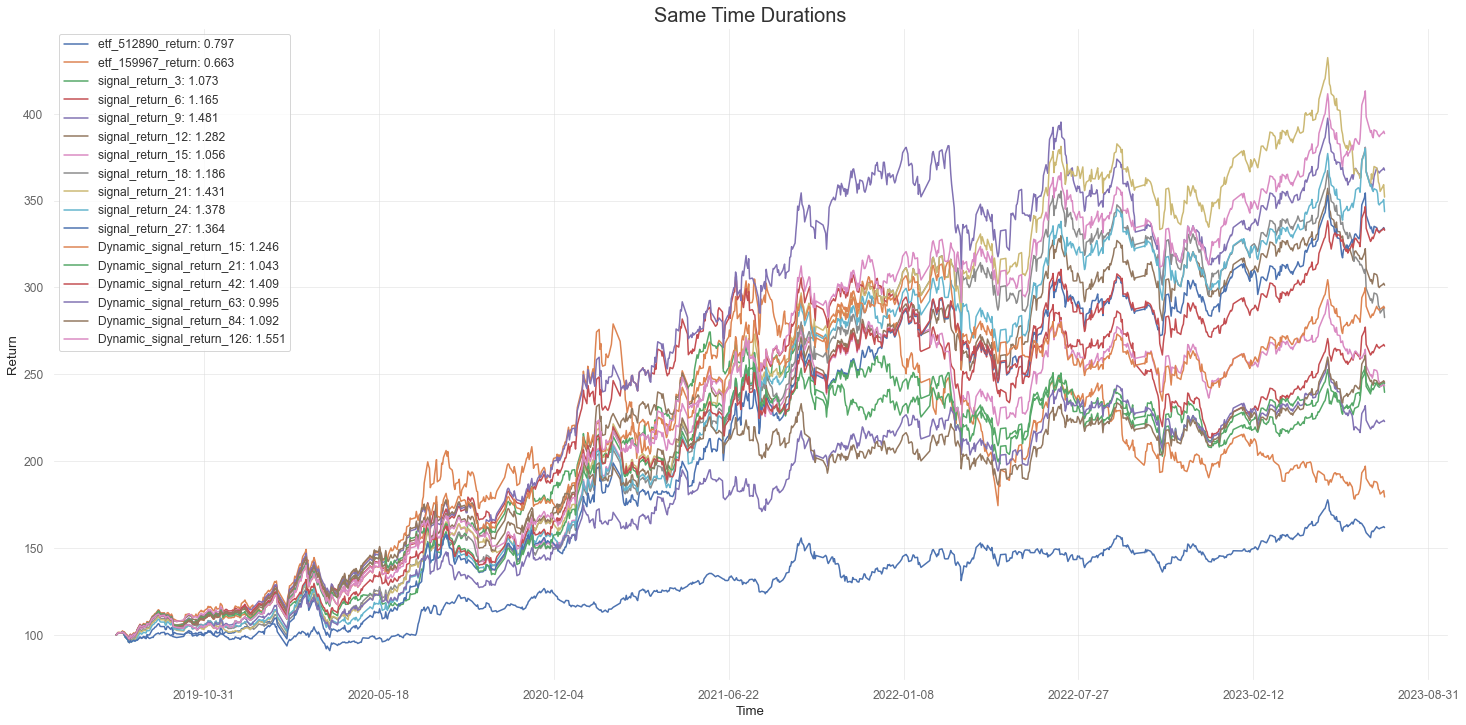

In [42]:
_ = plt.figure(figsize=(25, 12))
plt.xlabel('Time') 
plt.ylabel('Return')

_ = plt.plot(np.array(data_plot['etf_512890_return'].index),data_plot['etf_512890_return'].values)
_ = plt.plot(np.array(data_plot['etf_159967_return'] .index),data_plot['etf_159967_return'].values)


_ = plt.plot(np.array(optimized_table["signal_return_3"].index),optimized_table["signal_return_3"].values)
_ = plt.plot(np.array(optimized_table["signal_return_6"].index),optimized_table["signal_return_6"].values)
_ = plt.plot(np.array(optimized_table["signal_return_9"].index),optimized_table["signal_return_9"].values)
_ = plt.plot(np.array(optimized_table["signal_return_12"].index),optimized_table["signal_return_12"].values)
_ = plt.plot(np.array(optimized_table["signal_return_15"].index),optimized_table["signal_return_15"].values)
_ = plt.plot(np.array(optimized_table["signal_return_18"].index),optimized_table["signal_return_18"].values)
_ = plt.plot(np.array(optimized_table["signal_return_21"].index),optimized_table["signal_return_21"].values)
_ = plt.plot(np.array(optimized_table["signal_return_24"].index),optimized_table["signal_return_24"].values)
_ = plt.plot(np.array(optimized_table["signal_return_27"].index),optimized_table["signal_return_27"].values)


_ = plt.plot(np.array(dynamic_table_15["Dynamic_signal_return"].index),dynamic_table_15["Dynamic_signal_return"].values)
_ = plt.plot(np.array(dynamic_table_21["Dynamic_signal_return"].index),dynamic_table_21["Dynamic_signal_return"].values)
_ = plt.plot(np.array(dynamic_table_42["Dynamic_signal_return"].index),dynamic_table_42["Dynamic_signal_return"].values)
_ = plt.plot(np.array(dynamic_table_63["Dynamic_signal_return"].index),dynamic_table_63["Dynamic_signal_return"].values)
_ = plt.plot(np.array(dynamic_table_84["Dynamic_signal_return"].index),dynamic_table_84["Dynamic_signal_return"].values)
_ = plt.plot(np.array(dynamic_table_126["Dynamic_signal_return"].index),dynamic_table_126["Dynamic_signal_return"].values)



_ = plt.legend([f'etf_512890_return: {round(Sharpe_512890, 3)}', f'etf_159967_return: {round(Sharpe_159967, 3)}', 
                f'signal_return_3: {round(Sharpe_3, 3)}', f'signal_return_6: {round(Sharpe_6, 3)}',
                f'signal_return_9: {round(Sharpe_9, 3)}', f'signal_return_12: {round(Sharpe_12, 3)}',
                f"signal_return_15: {round(Sharpe_15, 3)}", f"signal_return_18: {round(Sharpe_18, 3)}", 
                f"signal_return_21: {round(Sharpe_21, 3)}", f"signal_return_24: {round(Sharpe_24, 3)}", 
                f"signal_return_27: {round(Sharpe_27, 3)}",  
                f"Dynamic_signal_return_15: {round(Sharpe_Dynamic_15, 3)}",f"Dynamic_signal_return_21: {round(Sharpe_Dynamic_21, 3)}", 
                f"Dynamic_signal_return_42: {round(Sharpe_Dynamic_42, 3)}",f"Dynamic_signal_return_63: {round(Sharpe_Dynamic_63, 3)}",
                f"Dynamic_signal_return_84: {round(Sharpe_Dynamic_84, 3)}",f"Dynamic_signal_return_126: {round(Sharpe_Dynamic_126, 3)}"]) 

plt.title("Same Time Durations", fontsize=20)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(200))

## -

## - 

## -

## Try out Rolling based on Volume and  [ON HOLD]

#### Set up

In [65]:

cnxn_jydb = pyodbc.connect('Driver={SQL Server};Server=192.168.0.144;Database=jydb;uid=zxing;pwd=zxing321')

def read_jydb(sql_query):
    return pd.read_sql(sql_query, cnxn_jydb)

def get_etf_daybar(secucode, begindate, enddate):
    sql_query = f"""
    SELECT b.[SecuCode] as 'secucode'
          ,[TradingDay] as 'tradingday'
          ,[OpenPrice] as 'open'
          ,[HighPrice] as 'high'
          ,[LowPrice] as 'low'
          ,[ClosePrice] as 'close'
          ,[TurnoverVolume] as 'volume'
          ,[TurnoverValue] as 'turnover'
          ,[PrevClosePrice] as 'prev_close'
    FROM [jydb].[dbo].QT_FundsPerformanceHis a ,SecuMain b
    where b.SecuCode = '{secucode}' and (TradingDay between '{begindate}' and '{enddate}') 
    and b.InnerCode = a.InnerCode and b.SecuCategory = 8
    order by TradingDay asc
    """

    df = read_jydb(sql_query)
    df['str_date'] = df['tradingday'].apply(lambda x: x.strftime('%Y%m%d'))
    df.set_index('tradingday', inplace=True, drop=True)
    return df


def get_idx_daybar(ulacode, begindate, enddate):
    sql_query = f"""
    SELECT c.[ULACode] as 'ulacode'
    ,[TradingDate] as 'tradingday'
    ,[OpenPrice] as 'open'
    ,[HighPrice] as 'high'
    ,[LowPrice] as 'low'
    ,[ClosePrice] as 'close'
    ,[Turnover] as 'turnover'
    FROM Opt_DailyQuote a ,Opt_OptionContract b, Opt_ULAContract c
    where c.ULACode = '{ulacode}' 
    and (TradingDate between '{begindate}' and '{enddate}') 
    and b.InnerCode = a.InnerCode
    and b.VarietyULAInnerCode = c.ULAInnerCode
    order by TradingDate asc
    """
    df = read_jydb(sql_query)
    df['str_date'] = df['tradingday'].apply(lambda x: x.strftime('%Y%m%d'))
    df.set_index('tradingday', inplace=True, drop=True)
    return df

In [66]:
get_etf_daybar('510050', 20000204, 20230713)

,secucode,open,high,low,close,volume,turnover,prev_close,str_date
tradingday,,,,,,,,,
2005-02-23,510050,0.881,0.882,0.866,0.876,126974.2542,1.111793e+09,0.887,20050223
2005-02-24,510050,0.876,0.876,0.868,0.876,45161.4223,3.941412e+08,0.876,20050224
2005-02-25,510050,0.877,0.887,0.875,0.880,50646.0695,4.465980e+08,0.876,20050225
2005-02-28,510050,0.878,0.879,0.870,0.872,18796.5193,1.644675e+08,0.880,20050228
2005-03-01,510050,0.870,0.873,0.865,0.867,20809.4456,1.805736e+08,0.872,20050301
...,...,...,...,...,...,...,...,...,...
2023-07-07,510050,2.544,2.549,2.532,2.539,35696.9708,9.073803e+08,2.550,20230707
2023-07-10,510050,2.551,2.571,2.544,2.552,34987.1690,8.946342e+08,2.539,20230710
2023-07-11,510050,2.563,2.573,2.555,2.569,37737.1480,9.679838e+08,2.552,20230711


In [69]:
optimized_table = Rolling.rolling_optimization_table(data, window_list, len(list_of_codes))

In [71]:
Rolling.get_data(list_of_codes)

Here at starting from the longest period


,etf_512890,etf_159967,etf_512890_day_return,etf_159967_day_return
EndDate,,,,
2018-12-21,0.9990,NaN,-0.001000,NaN
2018-12-28,0.9994,NaN,0.000400,NaN
2018-12-31,0.9998,NaN,0.000400,NaN
2019-01-04,1.0006,NaN,0.000800,NaN
2019-01-10,1.0007,NaN,0.000100,NaN
...,...,...,...,...
2023-07-07,1.8356,1.8654,0.002403,-0.011552
2023-07-10,1.8420,1.8800,0.003487,0.007827
2023-07-11,1.8460,1.8858,0.002172,0.003085


#### On Volume

## Next Step

<ol>
ETFs: '510050', '510300', '159915', '159901', '510500', '588000'
<br>
<br>
 <li> Conduct Experiments and Observe Effect on the performance of Dynamic Windows with Long and Short ( No more naked Long ) .</li>
 <br>
 <br>
 <li>Briefly Test the performance of the #1, #2, #3, or the N th return. The other variable should be set to be as either the "window_period_list" or the "look_back_period".</li>
 <br>
 <br>
 <li>After confirming the #1 returns the best, we set #1 as default and run a heatmap on the "window_period_list" and the "look_back_period".</li>
 <br>
 <br>
 <li>After Step 3, now we add RSI Threshold on the previous Dynamic Strategy, and consequently produce a heatmap.</li>
 <br>
 <br>
</ol>

In [ ]:
def dynamic_window_table_LS(data, window_list, target_num, days):
        """

        :param data: DataFrame from get_data
        :param window_list: [3,6,9,12,15,18,21,24,27]
        :param target_num: len(list_of_codes)
        :param days: int

        :return: data_x, signal_collecter
        """
        # parameter type: list, DataFrame, int
        data_copy = data.copy()

        # Set up a Dictionary with windows from window_list as keys and returns as values
        window_dict = {}
        last_window = 0
        for window in window_list:
             window_signal = signal_only(data_copy, [window], target_num)
             window_dict[window] = window_signal.iloc[:,-target_num:]

        # Set up a table that has full list of the signal_return from all of the given windows
        A = target_num
        signal_collecter = pd.DataFrame()
        optimized_table = Rolling.rolling_optimization_table(data, window_list, A)

        # Each Specific days the new window will be decided based on the past Specific days performance 
        for i in range(0,len(optimized_table)+days,days):
            reference_dict = {}
            # Set an upper limit for the loop
            if i + 2* days >= len(optimized_table):
                reference_table = optimized_table.iloc[len(signal_collecter):,:]
            # Select the part of reference table to match with the rotating dates
            else:
                reference_table = optimized_table.iloc[i:i+days,:]

            # Make sure the returns in the selected rotation are correctly calculated
            for column in reference_table.columns:
                first_value = reference_table.iloc[0][column]
                last_value = reference_table.iloc[-1][column]
                result = last_value / first_value
                reference_dict[column] = result

            rounded_result = []
            key_result = []
            for key, value in reference_dict.items():
                 rounded_values = round(value, 3)
                 rounded_result.append(rounded_values)
                 key_result.append(key)
 
            ## Decide the window to use for the next Specific days
            max_key = int(max(reference_dict, key=lambda k: reference_dict[k])[14:])

            # Here means the Max Key needs to be revised as there are multiple largest return 
            if rounded_result.count(max(rounded_result)) > 1:
                print(f'There are Repeating Max Return! Now we will select the one based on the last window {last_window}\n')
                print(f'The repeating max return here is {max(rounded_result)}')
                max_indices = [index for index, value in enumerate(rounded_result) if value == max(rounded_result)]  # Get indices of all occurrences of the maximum value
                # print(f'The repeating max return here is {max_indices}')
                values = [key_result[index] for index in max_indices]
                # print(f'Consequently, the corresponding keys are {values}')
                values = [int(value[14:]) for value in values]
                print(f'Here are the repeating windows: {values} given the last window was {last_window}')
                # print(f'The last window is {last_window}')

                closest_key = None

                for key in values:
                    # print(f'We have reached this rotation of key when key is {key}')
                    ## Change Close_Key when the next key has a smaller gap than the former
                    if closest_key is None or (abs(key - last_window) < abs(closest_key - last_window)):
                        closest_key = key
                        # print(f'We are at Step 1 and the cloest_key here was {closest_key} ')
                    if (abs(key - last_window) == abs(closest_key - last_window)) and key > closest_key:
                        closest_key = key
                            # print(f'We have reached Step 2 and the cloest_key now is {closest_key}')
                            
                # print('\n')
                # print(f'HENCE, our supposed choice of Max_Key should be {closest_key}')
                max_key = closest_key
            
            print(f'For the {int((i+days)/days)}th rotation, the window of choice is {max_key}\n')
           
            
            ################ print("_________________________________________________________________\n")
            # print(reference_table.index)

            selected_window_signal = window_dict[max_key].loc[optimized_table.iloc[i+days:i+2*days,:].index]
            print(selected_window_signal)
            print('\n')
            print('\n')
            signal_collecter = pd.concat([signal_collecter, selected_window_signal], axis=0, ignore_index=False)
            last_window = max_key
            if len(signal_collecter) >= len(data) - 4:
                 break
            if i + 2* days >= len(optimized_table):
                 break
            ################# print(f'The signal_collecter length now is {len(signal_collecter)}\n')
        
        ## Combine the data with the signal 
        data_x = data.loc[signal_collecter.index]
        data_x = pd.concat([data_x, signal_collecter], axis=1, ignore_index=False)
        ############## print(data_x)

        ## Now we calculate the return based on signals
        for name in data_x.columns[-A:]:
                data_x[name] = data_x[name].shift(1)
            
        data_x = data_x[1:]
        
        data_x['Dynamic_signal_return'] = [0] * len(data_x)
        arr = []
            
        for row in range(len(data_x)):
            value = data_x.iloc[row][2*A:3*A].max()
            series = data_x.iloc[row]
            ## find the position of signal with 1 
            position = series[2*A:3*A][series == value].idxmax()
            old_position = series.index.get_loc(position)
            new_position = old_position - A
            arr.append(series[new_position] + 1)
            
        data_x['arr'] = arr
        data_x['Dynamic_signal_return'] = np.cumprod(arr, axis=0)*100
        


        data_x['Dynamic_signal_return'] = (100/data_x['Dynamic_signal_return'].values[0]) * data_x['Dynamic_signal_return'] 
        ##################### print(f'This is {days} period rolling, we have the length of {len(signal_collecter)}\n')
        return data_x,signal_collecter
        
             